In [27]:
import os
import torch
import numpy as np
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from utils.oct_dataset import OCTDataset
from utils.lossfunctions import DiceLoss
from utils.models import ResNetUNetWithAttention, MedSAM
from segment_anything import sam_model_registry
import torchmetrics
from sklearn.metrics import roc_curve, auc

In [28]:
def save_image_with_prediction_and_mask(image, predicted, mask, image_id, save_dir, model_name):
    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    predicted_np = predicted.cpu().numpy().squeeze()
    mask_np = mask.cpu().numpy().squeeze()

    # Save the predicted and ground truth masks as images
    predicted_path = os.path.join(save_dir, f"{image_id}_predicted_{model_name}.png")
    mask_path = os.path.join(save_dir, f"{image_id}_mask_{model_name}.png")
    plt.imsave(predicted_path, predicted_np, cmap="gray")
    plt.imsave(mask_path, mask_np, cmap="gray")
    


In [29]:

def test_models(models_list, root_dir, save_dir):
    # Define device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initialize lists to store results
    model_names = []
    dice_coeffs = []
    image_ids = []
    probabilities = []
    true_labels = []

    # Define dataset and transformations
    transform = transforms.Compose([
        transforms.Resize((1024, 1024), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    test_dataset = OCTDataset("/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/data_gentuity",
        transform=transform,
        train=False,
        is_gentuity=True,
    )
    test_loader = DataLoader(torch.utils.data.Subset(test_dataset, range(5)), batch_size=1, shuffle=False, num_workers=4)

    # Define loss function
    criterion = DiceLoss()

    # Loop through models and test each one
    for model_name, model_config in models_list:
        print(f"Testing model: {model_name}")

        # Initialize the model
        if model_config["model"] == "Unet":
            net = smp.Unet(
                encoder_name="resnet50",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1,
            )
        elif model_config["model"] == "DeepLabV3+":
            net = smp.DeepLabV3Plus(
                encoder_name="resnet50",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1,
            )
        elif model_config["model"] == "MedSam":
            sam_model = sam_model_registry['vit_b'](checkpoint="utils/medsam_vit_b.pth")
            net = MedSAM(
                image_encoder=sam_model.image_encoder,
                mask_decoder=sam_model.mask_decoder,
                prompt_encoder=sam_model.prompt_encoder,
            )
            checkpoint = torch.load(model_config["checkpoint_path"], weights_only=True, map_location=torch.device('cpu'))
            net.load_state_dict(checkpoint[0])  # Assuming the checkpoint has a key 'model' for the weights
    
        elif model_config["model"] == "AttentionUnet":
            net = ResNetUNetWithAttention()

        # Load model checkpoint
        if(model_config["model"] != "MedSam"):
            checkpoint_path = model_config["checkpoint_path"]
            model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True, map_location=torch.device('cpu'))
            net.load_state_dict(model_state)
        
        net.to(device)
        net.eval()

        # Test the model
        model_dice_scores = []
        model_probs = []
        model_true_labels = []

        with torch.no_grad():  # Disable gradient calculation
            for image_id, data in enumerate(test_loader):
                if model_config["model"] == "MedSam":
                    # For MedSAM, process with bounding boxes
                    images, masks, _, _ = data
                    images, masks = images.to(device), masks.to(device)

                    # Get image dimensions
                    batch_size, _, height, width = images.size()

                    # Create bounding boxes covering the entire image
                    bboxes = torch.tensor([[0, 0, width, height]] * batch_size, dtype=torch.float32).unsqueeze(1).to(device)

                    # Predict outputs with bounding boxes
                    outputs = net(images, bboxes)
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs > 0.5).float()
                else:
                    # For other models
                    images, masks, _, _ = data
                    images, masks = images.to(device), masks.to(device)

                    outputs = net(images)
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs > 0.5).float()

                # Calculate loss dice score from torchmetrics
                dice_metric = torchmetrics.Dice()
                dice_score = dice_metric(predicted, masks.int())
                
                model_dice_scores.append(dice_score.item())
                print(f"Dice score: {dice_score.item():.4f}")

                model_probs.append(outputs.cpu().detach().numpy().flatten())
                model_true_labels.append(masks.cpu().detach().numpy().flatten())

                # Save image with predictions and ground truth mask
                save_image_with_prediction_and_mask(images[0], predicted[0], masks[0], image_id, save_dir, model_name)

                # Store image ID for plotting later
                image_ids.append(image_id)

                print(f"Progress: {len(model_dice_scores)} / {len(test_loader)}", end="\r")


        # Store results
        model_names.extend([model_name] * len(model_dice_scores))
        dice_coeffs.extend(model_dice_scores)
        probabilities.extend(model_probs)
        true_labels.extend(model_true_labels)


        print(f"{model_name} - Average Dice accuracy: {sum(model_dice_scores) / len(model_dice_scores):.4f}")
    
    return model_names, dice_coeffs, image_ids, probabilities, true_labels

models_list = [
    ("MedSAM Frozen", {"model": "MedSam", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/medsam_frozen_bs=6_dicebce.pth"}),
    ("MedSAM UnFrozen", {"model": "MedSam", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/medsam_unfrozen_bs=6_dicebce.pth"}),
    ("AttentionUnet Frozen", {"model": "AttentionUnet", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/attentionUnet_frozen_bs=6_dicebce.pt"}),
    ("AttentionUnet UnFrozen", {"model": "AttentionUnet", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/attentionUnet_unfrozen_bs=6_dicebce.pt"}),
    ("U-Net Frozen", {"model": "Unet", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/unet_frozen_bs=6_dicebce.pt"}),
    ("U-Net UnFrozen", {"model": "Unet", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/unet_unfrozen_bs=6_dicebce.pt"}),
    ("DeepLabV3+ Frozen", {"model": "DeepLabV3+", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/deeplab_frozen_bs=6_dicebce.pt"}),
    ("DeepLabV3+ UnFrozen", {"model": "DeepLabV3+", "checkpoint_path": "/Users/studiesamuel/Library/CloudStorage/OneDrive-Aarhusuniversitet/Deep Learning/checkpoints/deeplab_unfrozen_bs=6_dicebce.pt"}),
]

root_dir = ""
save_dir = "output_images"  # Directory to save images with predictions
os.makedirs(save_dir, exist_ok=True)


In [ ]:
# Run the function to get Dice scores and model names
model_names, dice_coeffs, image_ids, probabilities, true_labels = test_models(models_list, root_dir, save_dir)

results_df = pd.DataFrame({
    "Model": model_names,
    "Dice Score": dice_coeffs,
    "Image ID": image_ids,
    "Prediction value": probabilities,
    "True label": true_labels
})

Testing model: MedSAM Frozen


/Users/studiesamuel/repos/MedSAM/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.device('cpu')

Dice score: 0.9661
Dice score: 0.9642
Dice score: 0.9633
Dice score: 0.9634
Dice score: 0.9485
MedSAM Frozen - Average Dice accuracy: 0.9611
Testing model: MedSAM UnFrozen
Dice score: 0.9315
Dice score: 0.9528
Dice score: 0.9422
Dice score: 0.9426
Dice score: 0.9013
MedSAM UnFrozen - Average Dice accuracy: 0.9341
Testing model: AttentionUnet Frozen
Dice score: 0.6350
Dice score: 0.7447
Dice score: 0.6126
Dice score: 0.6237
Dice score: 0.5703
AttentionUnet Frozen - Average Dice accuracy: 0.6373
Testing model: AttentionUnet UnFrozen
Dice score: 0.8718
Dice score: 0.8837
Dice score: 0.8667
Dice score: 0.8603
Dice score: 0.8469
AttentionUnet UnFrozen - Average Dice accuracy: 0.8659
Testing model: U-Net Frozen
Dice score: 0.4998
Dice score: 0.5023
Dice score: 0.4971
Dice score: 0.4904
Dice score: 0.4931
U-Net Frozen - Average Dice accuracy: 0.4965
Testing model: U-Net UnFrozen
Dice score: 0.8745
Dice score: 0.9093
Dice score: 0.8792
Dice score: 0.8644
Dice score: 0.8538
U-Net UnFrozen - Ave

In [ ]:


# Save the results to a csv file containing the model names and dice scores, and image_ids
results_df.to_csv("results_test_trained_on_terumo.csv", index=False)

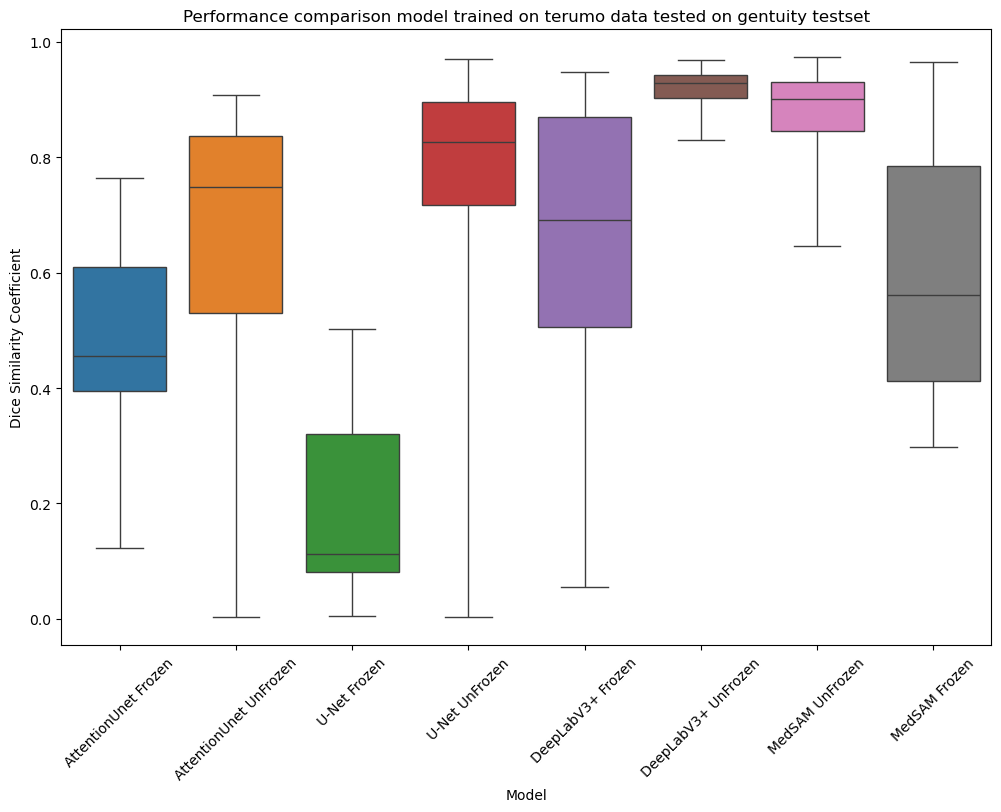

In [11]:
# Create a DataFrame from the csv for visualization
results_df = pd.read_csv("results_test_trained_on_terumo_tested_on_gentuity_run1.csv")

# Generate a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="Model", y="Dice Score", data=results_df, hue="Model", whis=[0, 100])
plt.title("Performance comparison model trained on terumo data tested on gentuity testset")
plt.ylabel("Dice Similarity Coefficient")
plt.xticks(rotation=45)
plt.show()

In [26]:
# Calculate the average dice score for each model
average_dice_scores = results_df.groupby("Model")["Dice Score"].mean()
print(average_dice_scores)

Model
AttentionUnet Frozen      0.486145
AttentionUnet UnFrozen    0.646852
DeepLabV3+ Frozen         0.649474
DeepLabV3+ UnFrozen       0.920048
MedSAM Frozen             0.601439
MedSAM UnFrozen           0.879806
U-Net Frozen              0.178712
U-Net UnFrozen            0.781156
Name: Dice Score, dtype: float64


Processing model: MedSAM Frozen
Processing model: MedSAM UnFrozen
Processing model: AttentionUnet Frozen
Processing model: AttentionUnet UnFrozen
Processing model: U-Net Frozen
Processing model: U-Net UnFrozen
Processing model: DeepLabV3+ Frozen
Processing model: DeepLabV3+ UnFrozen


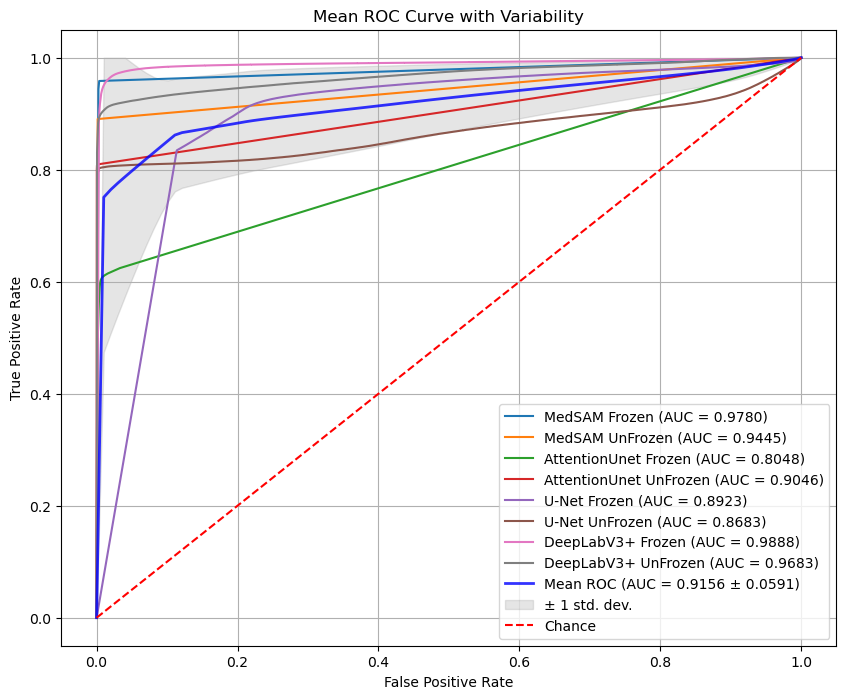

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from scipy.interpolate import interp1d

def plot_roc_curves_from_df(results_df):
    """
    Generate and plot ROC curves for multiple models based on DataFrame containing predictions and true labels.
    """
    # Define the number of points on the FPR axis
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []  # True Positive Rates for each model
    aucs = []  # AUCs for each model
    
    # Prepare a plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get unique model names
    model_names = results_df['Model'].unique()

    for model_name in model_names:
        print(f"Processing model: {model_name}")
        
        # Filter data for the current model
        model_data = results_df[results_df['Model'] == model_name]
        
        # Initialize empty lists to store true labels and predictions
        true_labels = []
        predictions = []

        # Iterate through the data rows and get arrays directly
        for _, row in model_data.iterrows():
            true_label = row['True label']  # This is already an array
            prediction = row['Prediction value']  # This is already an array

            # Ensure that true_label contains only 0 or 1 (binary classification)
            true_label = (true_label > 0).astype(int)  # Convert to binary 0 or 1

            # Append the arrays to the lists
            true_labels.append(true_label)
            predictions.append(prediction)

        # Convert the lists of arrays into single flattened arrays
        true_labels = np.concatenate(true_labels)
        predictions = np.concatenate(predictions)
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(true_labels, predictions)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Plot the individual ROC curve
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

        # Interpolate TPR for mean ROC calculation
        tpr_interp = interp1d(fpr, tpr, bounds_error=False, fill_value=0)(mean_fpr)
        tpr_interp[0] = 0.0  # Ensure the curve starts from (0,0)
        tprs.append(tpr_interp)

    # Calculate mean TPR and variability when there are multiple models
    if len(tprs) > 1:
        mean_tpr = np.mean(tprs, axis=0)
    else:
        # If only one model, use that TPR directly
        mean_tpr = tprs[0]

    mean_tpr[-1] = 1.0  # Ensure that the last TPR is 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plot the mean ROC curve
    ax.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})", lw=2, alpha=0.8)

    # Plot variability as shaded region
    if len(tprs) > 1:  # Only plot variability if multiple models are present
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label="± 1 std. dev.")

    # Finalize the plot
    ax.plot([0, 1], [0, 1], 'r--', label="Chance")
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Mean ROC Curve with Variability"
    )
    ax.legend(loc="lower right")
    plt.grid()
    plt.show()

# Assuming `results_df` is your DataFrame containing the predictions
# Call the function directly with the DataFrame
plot_roc_curves_from_df(results_df)
